In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations, HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalStationaryTransitions, HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions, HierarchicalNeuralNetworkRecurrentTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [61]:
# Specify hyperparameters
D = 10   # dimensionality of continuous latent states
M = 0   # dimensionality of input
results_dir = "results/kato/2018-09-19/D{}".format(D)

In [62]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]
dys = [np.gradient(y, axis=0) * 10 for y in ys]

K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


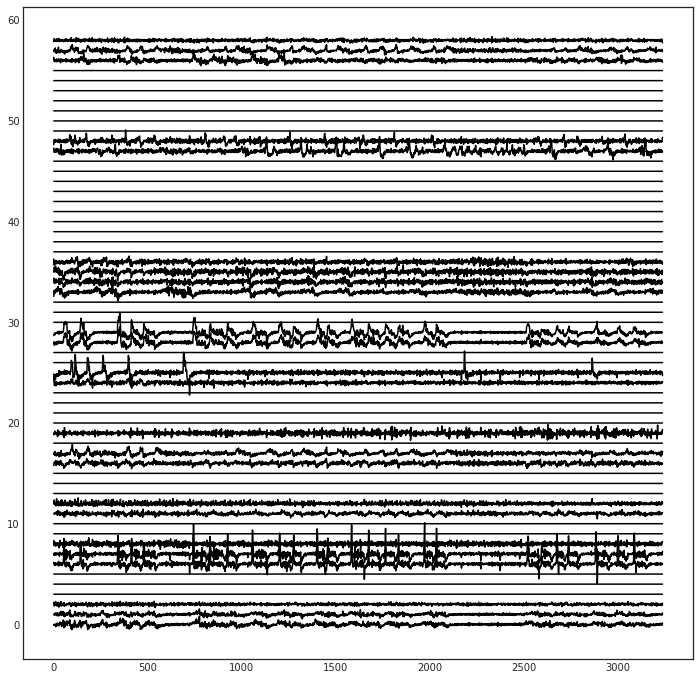

In [63]:
plt.figure(figsize=(12, 12))
plt.plot(dys[0] + np.arange(N), '-k')

In [64]:
full_ys = [np.hstack((y, dy)) for y, dy in zip(ys, dys)]
full_ms = [np.hstack((m, m)) for m in ms]

# Dimensionality reduction on $\Delta$F/F 

In [65]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(D, full_ys, full_ms)

lim = 1.1 * abs(np.vstack(xs)).max()

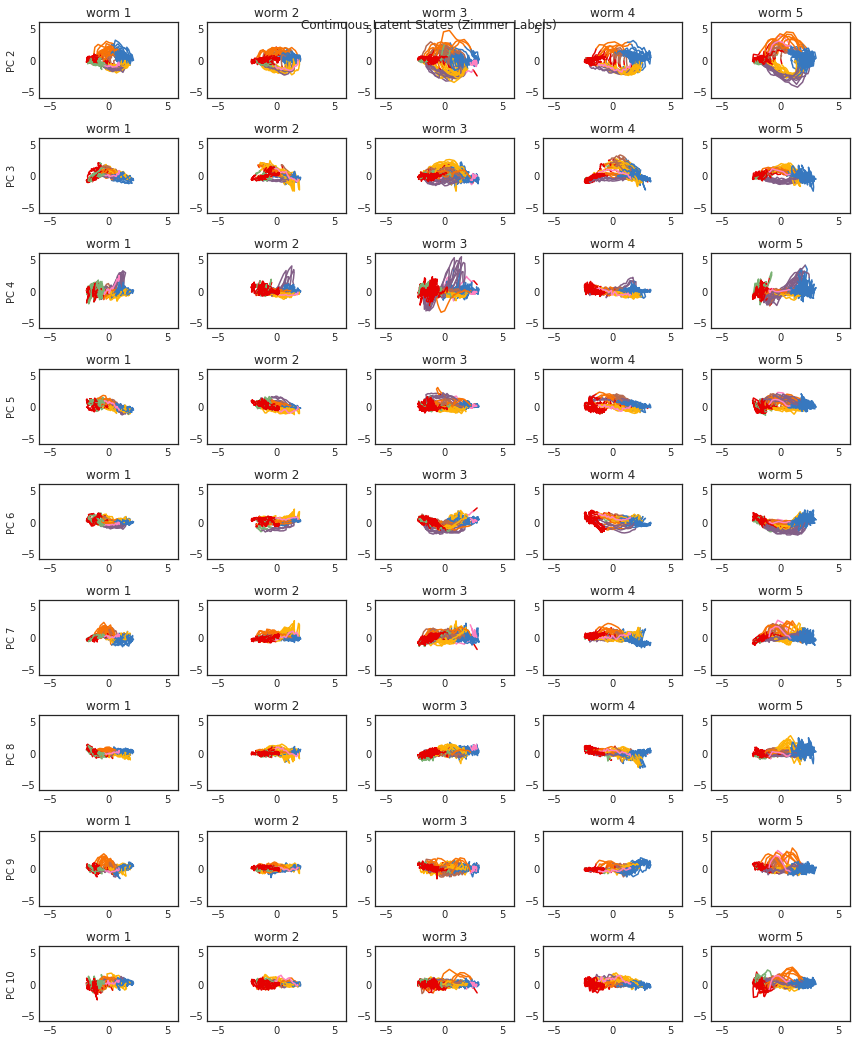

In [66]:
plt.figure(figsize=(12, 16))
for w, (x, z) in enumerate(zip(xs, z_trues)):
    for d in range(1, D):
        ax = plt.subplot(D, W, (d-1) * W + w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, d), ax=ax)
        plt.ylabel("PC {}".format(d+1) if w == 0 else "")
        plt.title("worm {}".format(w+1))

plt.suptitle("Continuous Latent States (Zimmer Labels)")
plt.tight_layout()

# Reconstruct from PCA

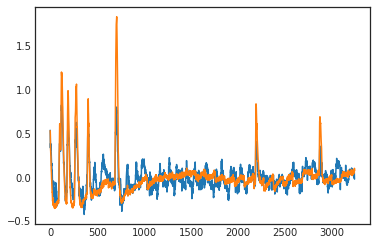

In [70]:
C = pca.components_.T
d = pca.mean_
y_hats = [x.dot(C.T) + d for x in xs]

n = np.where(ms[0][0])[0][12]
plt.plot(y_hats[0][:,n])
plt.plot(ys[0][:,n])